# Predicting ground states for 2D Heisenberg models

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from munch import Munch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from train import main as train_new
from train_kernel import main as train_kernel
from train import parse_args as default_parser
from eval_utils import get_results, convert_df, calc_trainsize, convert_df_v2


2023-07-21 14:22:35.419204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /system/apps/biosoft/gcc-9.1.0/lib64:/system/apps/biosoft/gcc-9.1.0/lib:/system/apps/mlsoft/cuda-11.6//lib64:/system/apps/biosoft/gcc-9.1.0/lib64:/system/apps/biosoft/gcc-9.1.0/lib:/system/apps/mlsoft/cuda-11.6//lib64:
2023-07-21 14:22:35.419411: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /system/apps/biosoft/gcc-9.1.0/lib64:/system/apps/biosoft/gcc-9.1.0/lib:/system/apps/mlsoft/cuda-11.6//lib64:/system/apps/biosoft/gcc-9.1.0/lib64:/system/apps/biosoft/gcc-9.1.0/lib:/system/apps/mlsoft/cuda-11.6//lib64:
2023-07-21 14:22:35.419427: W tens

In [ ]:
nrow = 9
test_size = 0.9 # thus train_size = 50 

shadow_size_it = [1000, 500, 250, 100, 50]
nparallel = int(os.cpu_count() * 0.50)


Before we start the calculations make sure that the dataset was prepared by calling `python dataloader.py`. Also make sure that the kernels are prepared by calling `python kernels.py`.

Make sure that the folder `clean_results` does not contain any important data since we will overwrite any existing files. It is best to start with an empty `clean_results` folder or delete it since remnant result files will slow down the analysis.

# do calculations

In [ ]:
if os.path.exists("clean_results"):
    if os.listdir("clean_results") == []:
        print("clean_results exists and is empty. Can proceed")
    else:
        raise Warning("clean_results exists and is not empty. Proceed with caution!")
else:
    os.mkdir("clean_results")
    print("created clean_results folder")


In [ ]:
# for new algo
parser = default_parser(return_parser=True, default_algo='new')
base_args = vars(parser.parse_args([]))
for shadow_size in shadow_size_it:
    args_dict = base_args.copy()
    
    args_dict.update({
        'test_size': test_size,
        'shadow_size': shadow_size,
        'nrow': nrow,
        #
        #'pbar': False,
    })
    args_dict.update({
        'lasso_lib': 'celer',
        'lasso_tol': 1e-3,
        'lasso_maxiter': 10000,
        'lasso_maxep': 50000,
    })

    args = Munch(args_dict)
    train_new(args)


In [ ]:
# orig method
parser = default_parser(return_parser=True, default_algo='orig')
base_args = vars(parser.parse_args([]))
for shadow_size in shadow_size_it:
    args_dict = base_args.copy()
    
    args_dict.update({
        'test_size': test_size,
        'shadow_size': shadow_size,
        'nrow': nrow,
        #
        #'pbar': False,
    })
    args_dict.update({
        'dirichlet_size_factor': 4,
        'ntk_normalization': False,
        'svr_tol': 1e-3,
    })

    args = Munch(args_dict)
    train_kernel(args)


In [ ]:
# runs can be done in parallel as follows:
# from joblib import Parallel, delayed
# from tqdm_joblib import tqdm_joblib

# def process_starter(args):
#     if args.algo_type == 'new':
#         train_new(args)
#     elif args.algo_type == 'orig':
#         train_kernel(args)
#     return args
#
# with tqdm_joblib(desc="Experiment", total=len(args_list)) as pbar:
#         res = Parallel(n_jobs=nparallel)(
#             delayed(process_starter)(a) for a in args_list)

# read in data

In [2]:
df = get_results('./clean_results')
#df.to_excel('./clean_results/results_all.xlsx')

## get_results() can be parallelized by modifying the code in eval_utils.py
## just add the following lines to eval_utils.py
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

## and redefine get_results() as follows:
# def get_results(globpath):
#     files = glob(os.path.join(globpath,'**/results*.txt'), recursive=True)
#     df = pd.DataFrame({'path':files})
#     print(f"Found {len(df)} files")
#     df = df.parallel_apply(extract, axis=1)
#     print(f"Extracted parameters from {len(df)} paths")
#     df = df.parallel_apply(read_results, axis=1)
#     print(f"Read in {len(df)} files")
#     df = df.apply(calc_nsamples, axis=1)
#     df33 = df.apply(calc_avg, axis=1)
#     return df


Found 600 files


100%|██████████| 600/600 [00:01<00:00, 416.16it/s]


Extracted parameters from 600 paths


100%|██████████| 600/600 [00:07<00:00, 76.22it/s] 


Read in 600 files


In [3]:
df.algo_setting.unique()

array(['new_algorithm_500data_sklearn_maxiter=10000_tol=0.001_seed=42',
       'orig_algorithm_svrtol=0.001_ntk-norm=False_diri-inclx=True_diri-sf=4_seed=42',
       'new_algorithm_sklearn_maxiter=10000_tol=0.001_seed=42',
       'orig_algorithm_500data_svrtol=0.001_ntk-norm=False_diri-inclx=True_diri-sf=4_seed=42'],
      dtype=object)

In [ ]:

# # chosing only algo with inst-nomr=True for orig algos
# blacklist_algs = []
# for alg in df.algo_setting.unique():
#     if alg.startswith('orig_algorithm'):
#         if alg.endswith('inst-norm=False'):
#             blacklist_algs.append(alg)

# df = df[~df.algo_setting.isin(blacklist_algs)]

In [4]:
df = convert_df(df)

dropping 11 columns: ['path', 'nedges', 'algo_setting', 'algo_suffix', 'dirinclx', 'dirsf', 'maxiter', 'ncol', 'ntknorm', 'srvtol', 'tol']


convert orig-algo data format: 100%|██████████| 1800/1800 [00:00<00:00, 4115.64it/s]
/system/user/tran/zelle/improved-ml-algorithm/eval_utils.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['method'] = 'new'
convert new-algo data format: 100%|██████████| 300/300 [00:00<00:00, 9781.42it/s]


unique values per column: 
column testsize:	unique values: [0.9 0.7 0.5 0.3 0.1]
column shadowsize:	unique values: [ 100  500 1000   50  250]
column qubitdist:	unique values: [1]
column nrow:	unique values: [4 9 8 6 7 5]
column dataname:	unique values: ['orig' 'new']
column nsamples:	unique values: [ 90.   80.1  82.8  87.3  70.   62.3  64.4  67.9  50.   44.5  46.   48.5
  30.   26.7  27.6  29.1  10.    8.9   9.2   9.7 450.  350.  250.  150. ]
column seed:	unique values: [42]
column method:	unique values: ['dirichlet' 'gauss' 'ntk2' 'ntk3' 'ntk4' 'ntk5' 'new']
column algo:	unique values: ['orig' 'new']
column edge:	unique values: [(1, 2) (1, 6) (2, 3) (2, 7) (3, 4) (3, 8) (4, 5) (4, 9) (5, 10) (6, 7)
 (6, 11) (7, 8) (7, 12) (8, 9) (8, 13) (9, 10) (9, 14) (10, 15) (11, 12)
 (11, 16) (12, 13) (12, 17) (13, 14) (13, 18) (14, 15) (14, 19) (15, 20)
 (16, 17) (17, 18) (18, 19) (19, 20) (16, 21) (17, 22) (18, 23) (19, 24)
 (20, 25) (21, 22) (21, 26) (22, 23) (22, 27) (23, 24) (23, 28) (24, 25)

# plot

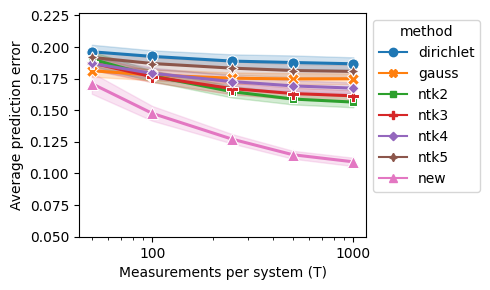

In [5]:
fig=plt.figure(figsize=(5, 3.0))
ax = sns.lineplot(
    data=df[(df['dataname'] == "new") & (df['nrow'] == 9) & (df['qubitdist'] == 1) & (df['train_samples_new'] == 50)],
    x='shadowsize',
    y='test_score',
    hue='method',
    style='method',
    markers=True,#['o', 'D'],
    dashes=False,
    markersize=8.1,
    linewidth = 2.2,
    #palette=[sns.color_palette("muted")[7], sns.color_palette("Set2")[2]],
    #hue_order=['orig', 'new']
)
sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel(r'Measurements per system (T)')
plt.ylabel('Average prediction error')
plt.xscale('log')
plt.ylim(0.05, 0.227)
#ax.set_xticks([60, 125, 250, 500, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.legend([],[], frameon=False)
#     plt.legend(title='', labels=['Previous work', 'Gaussian', r'$\infty$-width NN', 'This work'])
plt.tight_layout()
plt.savefig('shadow-size.png', dpi=300)

# transform table format to same one used in Code notebook

In [6]:
df3 = convert_df_v2(df)

# reproduce Plots in Code.ipynb


In [7]:

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import ast
import numpy as np
import os
import pandas as pd
import seaborn as sns

# for plotting prediction error:
sns.set(style="ticks")
# df3 = pd.read_excel('./clean_results_old/results_new.xlsx')


# only using data where we have both previous method and new method data
df3 = df3.dropna()
algo_mapping = {
    'Best Previous1': 'Previous work (Dirichlet kernel)',
    'Best Previous2': 'Gaussian kernel',
    'Best Previous3': 'Infinite-width NN',
    'New': 'This work',
}
df3['Algorithm'] = df3['Algorithm'].map(algo_mapping)



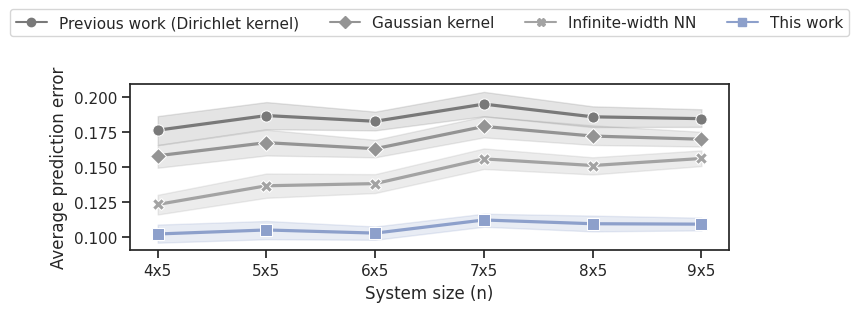

In [8]:

# Training Size New has to be selected via interval instead of == since we calculate it exactly 
# for some nrows some samples were missing thus we dont always have exactly 70 samples 
fig=plt.figure(figsize=(8.3, 4.0))
temp_df = df3[(df3['Data Set'] == "orig") & (df3['Distance'] == 1) & 
            (df3['Training Size New'] > 60) & (df3['Training Size New'] < 80) &
            (df3['Shadow Size'] == 500)]
# temp_df = df3[(df3['Data Set'] == "new") & (df3['Distance'] == 1) & 
#             (df3['Training Size New'] == 150) & (df3['Shadow Size'] == 500)]
temp_df = temp_df.sort_values(by=['System Size'])
algo_order = ['Previous work (Dirichlet kernel)', 'Gaussian kernel', 'Infinite-width NN', 'This work']
# dirichlet, gaussian, ntk, new
sns.lineplot(
    data=temp_df,
    x='System Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.legend([],[], frameon=False)
plt.legend(title='', ncol=4, bbox_to_anchor=(0.5, 1.5), loc="upper center")
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size-for-legend.png', dpi=300)


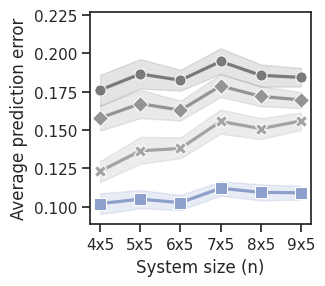

In [9]:

fig=plt.figure(figsize=(3.3, 3.0))
temp_df = df3[(df3['Data Set'] == "orig") & (df3['Distance'] == 1) & 
    (df3['Training Size New'] > 60) & (df3['Training Size New'] < 80) & (df3['Shadow Size'] == 500)]
temp_df = temp_df.sort_values(by=['System Size'])

sns.lineplot(
    data=temp_df,
    x='System Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.ylim(0.0885, 0.227)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size.png', dpi=300)


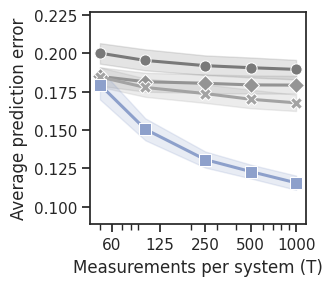

In [10]:
temp_df = df3[(df3['Data Set'] == "orig") & (df3['System Size'] == '9x5') & (df3['Distance'] == 1) & 
(df3['Training Size New'] > 40) & (df3['Training Size New'] < 60)]

fig=plt.figure(figsize=(3.3, 3.0))
ax = sns.lineplot(
    data=temp_df,
    x='Shadow Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.1,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel('Measurements per system (T)')
plt.ylabel('Average prediction error')
plt.xscale('log')
plt.ylim(0.0885, 0.227)
ax.set_xticks([60, 125, 250, 500, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/shadow-size.png', dpi=300)


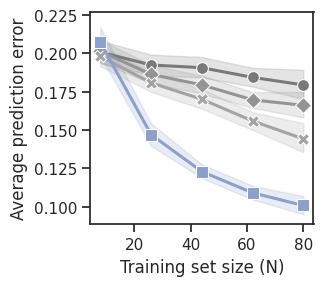

In [11]:
temp_df = df3[(df3['Data Set'] == "orig") & (df3['System Size'] == '9x5') & (df3['Distance'] == 1) & 
              (df3['Shadow Size'] == 500)]
fig=plt.figure(figsize=(3.3, 3.0))
sns.lineplot(
    data=temp_df,
    x='Training Size New',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.5,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel('Training set size (N)')
plt.ylabel('Average prediction error')
plt.ylim(0.0885, 0.227)
plt.legend([],[], frameon=False)
#     plt.legend(title='', labels=['Previous work', 'Gaussian', r'$\infty$-width NN', 'This work'])
plt.tight_layout()
# plt.savefig('./prediction_error_plots/training-size.png', dpi=300)


# repeat plots for new data

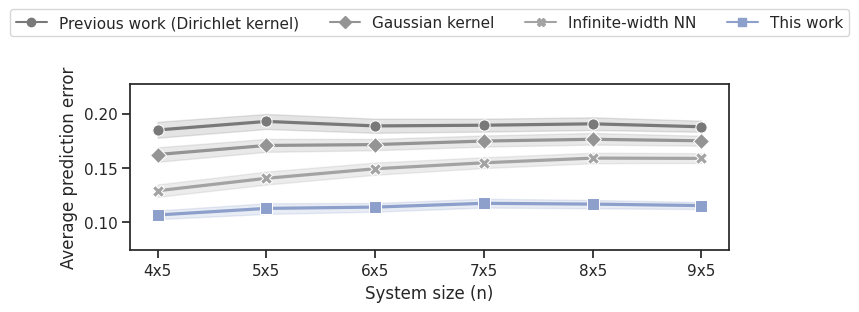

In [12]:
fig=plt.figure(figsize=(8.3, 4.0))
temp_df = df3[(df3['Data Set'] == "new") & (df3['Distance'] == 1) & 
            (df3['Training Size New'] == 50) & (df3['Shadow Size'] == 500)]
temp_df = temp_df.sort_values(by=['System Size'])
algo_order = ['Previous work (Dirichlet kernel)', 'Gaussian kernel', 'Infinite-width NN', 'This work']

# dirichlet, gaussian, ntk, new
sns.lineplot(
    data=temp_df,
    x='System Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.ylim(0.0735, 0.227)
plt.legend(title='', ncol=4, bbox_to_anchor=(0.5, 1.5), loc="upper center")
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size-for-legend_newdata.png', dpi=300)


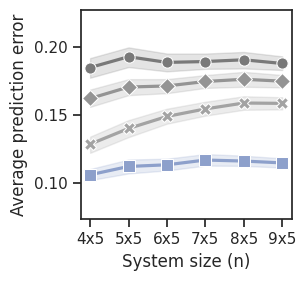

In [13]:

fig=plt.figure(figsize=(3.3, 3.0))
temp_df = df3[(df3['Data Set'] == "new") & (df3['Distance'] == 1) & 
    (df3['Training Size New'] == 50) & (df3['Shadow Size'] == 500)]
temp_df = temp_df.sort_values(by=['System Size'])

sns.lineplot(
    data=temp_df,
    x='System Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.ylim(0.0735, 0.227)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size_newdata.png', dpi=300)


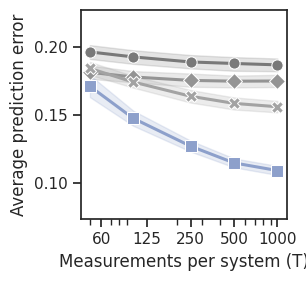

In [14]:
temp_df = df3[(df3['Data Set'] == "new") & (df3['System Size'] == '9x5') & (df3['Distance'] == 1) & 
(df3['Training Size New'] == 50)]
temp_df = temp_df.sort_values(by=['Shadow Size'])

fig=plt.figure(figsize=(3.3, 3.0))
ax = sns.lineplot(
    data=temp_df,
    x='Shadow Size',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.1,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel('Measurements per system (T)')
plt.ylabel('Average prediction error')
plt.xscale('log')
plt.ylim(0.0735, 0.227)
ax.set_xticks([60, 125, 250, 500, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/shadow-size_newdata.png', dpi=300)


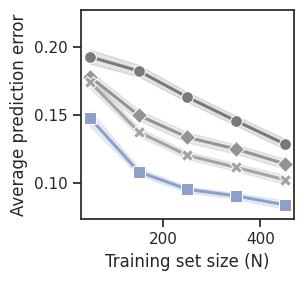

In [15]:
temp_df = df3[(df3['Data Set'] == "new") & (df3['System Size'] == '9x5') & (df3['Distance'] == 1) & 
              (df3['Shadow Size'] == 100)]
            #   (df3['Training Size New'] <= 150)]
fig=plt.figure(figsize=(3.3, 3.0))
sns.lineplot(
    data=temp_df,
    x='Training Size New',
    y='Prediction Error',
    hue='Algorithm',
    hue_order=algo_order,
    style='Algorithm',
    style_order=algo_order,
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.5,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel('Training set size (N)')
plt.ylabel('Average prediction error')
plt.ylim(0.0735, 0.227)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/training-size_newdata.png', dpi=300)
